# Preliminary Models

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Data

In [2]:
query = '''
    SELECT *
    FROM prod.features
    WHERE "Season Type" = 'NCAA Tourney' and
        holdout_s2 = 0
'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df = pd.read_sql_query(query, conn)

# "Diff" Features
df['AvgRankDiff'] = df['AvgRank'] - df['OpponentAvgRank']
df['AvgNetPointsForDiff'] = df['AvgNetPointsFor'] - df['OpponentAvgNetPointsFor']
df['TwoPointPctDiff'] = df['TwoPointPct_Team'] - df['TwoPointPct_Opponent']
df['ThreePointPctDiff'] = df['ThreePointPct_Team'] - df['ThreePointPct_Opponent']
df['FreeThrowPctDiff'] = df['FreeThrowPct_Team'] - df['FreeThrowPct_Opponent']
df['OffensiveReboundsDiff'] = df['OffensiveRebounds_Team'] - df['OffensiveRebounds_Opponent']
df['DefensiveReboundsDiff'] = df['DefensiveRebounds_Team'] - df['DefensiveRebounds_Opponent']
df['FieldGoalPctDiff'] = df['FieldGoalPct_Team'] - df['FieldGoalPct_Opponent']
df['TwoPointAttPctDiff'] = df['TwoPointAttPct_Team'] - df['TwoPointAttPct_Opponent']
df['ThreePointAttPctDiff'] = df['ThreePointAttPct_Team'] - df['ThreePointAttPct_Opponent']
df['FieldGoalAttDiff'] = df['FieldGoalAtt_Team'] - df['FieldGoalAtt_Opponent']
df['TwoPointAttDiff'] = df['TwoPointAtt_Team'] - df['TwoPointAtt_Opponent']
df['ThreePointAttDiff'] = df['ThreePointAtt_Team'] - df['ThreePointAtt_Opponent']
df['FreeThrowAttDiff'] = df['FreeThrowAtt_Team'] - df['FreeThrowAtt_Opponent']
df['AssistsDiff'] = df['Assists_Team'] - df['Assists_Opponent']
df['TurnoversDiff'] = df['Turnovers_Team'] - df['Turnovers_Opponent']
df['StealsDiff'] = df['Steals_Team'] - df['Steals_Opponent']
df['BlocksDiff'] = df['Blocks_Team'] - df['Blocks_Opponent']
df['PersonalFoulsDiff'] = df['PersonalFouls_Team'] - df['PersonalFouls_Opponent']

df_train = df[df['holdout_s1'] == 0]
df_test = df[df['holdout_s1'] == 1]

In [130]:
df_train.head()

,Season,DayNum,Team,Opponent,Outcome,Score,OpponentScore,NumOT,WLoc,Season Type,...,ThreePointAttPctDiff,FieldGoalAttDiff,TwoPointAttDiff,ThreePointAttDiff,FreeThrowAttDiff,AssistsDiff,TurnoversDiff,StealsDiff,BlocksDiff,PersonalFoulsDiff
0,2003,134,1411,1421,0,84,92,1,N,NCAA Tourney,...,0.018985,-1.4052,-2.0948,0.6897,7.4286,1.0012,-0.9076,-0.48276,-0.68719,-0.8300
1,2003,134,1421,1411,1,92,84,1,N,NCAA Tourney,...,-0.018985,1.4052,2.0948,-0.6897,-7.4286,-1.0012,0.9076,0.48276,0.68719,0.8300
2,2003,136,1173,1409,0,71,84,0,N,NCAA Tourney,...,0.055042,-2.9167,-4.8524,1.9357,3.7810,0.1690,-0.9071,-2.03571,-1.93571,0.5524
3,2003,136,1181,1161,1,67,57,0,N,NCAA Tourney,...,0.111978,8.1380,-0.7242,8.8620,3.1380,-1.6207,-2.0690,3.17241,0.93103,0.6207
4,2003,136,1211,1153,1,74,69,0,N,NCAA Tourney,...,0.001516,-1.2074,-0.7481,-0.4593,3.2704,3.5740,3.8000,1.57407,-0.64074,-0.6481


In [5]:
df_test.head()

,Season,DayNum,Team,Opponent,Outcome,Score,OpponentScore,NumOT,WLoc,Season Type,...,ThreePointAttPctDiff,FieldGoalAttDiff,TwoPointAttDiff,ThreePointAttDiff,FreeThrowAttDiff,AssistsDiff,TurnoversDiff,StealsDiff,BlocksDiff,PersonalFoulsDiff
1426,2014,134,1107,1291,1,71,64,0,N,NCAA Tourney,...,-0.161155,-7.3226,4.2580,-11.5806,0.2259,-0.6129,0.70970,-1.77420,0.03225,-1.5807
1427,2014,134,1291,1107,0,64,71,0,N,NCAA Tourney,...,0.161155,7.3226,-4.2580,11.5806,-0.2259,0.6129,-0.70970,1.77420,-0.03225,1.5807
1428,2014,134,1301,1462,1,74,59,0,N,NCAA Tourney,...,-0.010315,3.2708,3.1705,0.1004,-2.1269,-1.9668,-2.10980,-1.18087,0.99905,-1.0842
1429,2014,134,1462,1301,0,59,74,0,N,NCAA Tourney,...,0.010315,-3.2708,-3.1705,-0.1004,2.1269,1.9668,2.10980,1.18087,-0.99905,1.0842
1430,2014,135,1142,1411,1,81,69,0,N,NCAA Tourney,...,0.020573,-0.5529,-1.7374,1.1847,-8.8243,-2.2636,-4.15902,0.90879,-0.89544,2.2492


## Baseline Metrics

- Log Loss value for all predicted probabilites == 0.5
- Log Loss value if every prediction was wrong with 100% confidence

In [3]:
target = 'Outcome'

# baseline of 0.5
baseline = np.full(536, 0.5)
print("Baseline: ",log_loss(df_test[target],baseline))

# worst case scenario -- every prediction was wrong with 100% confidence
print("Completely Wrong: ",log_loss(df_test[target],1-df_test[target]))

Baseline:  0.69314718056
Completely Wrong:  34.5391761936


In [4]:
target = 'Outcome'
features = ['SeedDiff']

lr = LogisticRegression()
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.69      0.75      0.72       268
          1       0.73      0.67      0.70       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.571490292973
RMSE:  0.196131801918
ROC AUC:  0.770981844509


## Logistic Regression

In [10]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPct', 'OpponentWinPct',
            'AvgNetPointsFor', 'OpponentAvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

lr = LogisticRegression(penalty='l2')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.543489397983
RMSE:  0.184835817665
ROC AUC:  0.79476219648


In [11]:
for i in zip(features, lr.coef_.flatten()):
    print("{:<30} {:>8.4f}".format(i[0],i[1]))

SeedDiff                        -0.0710
WinPct                          -0.4431
OpponentWinPct                   0.4431
AvgNetPointsFor                  0.0889
OpponentAvgNetPointsFor         -0.0889
AvgRank                         -0.0117
OpponentAvgRank                  0.0117
TwoPointPct_Team                 0.1310
TwoPointPct_Opponent            -0.1310
ThreePointPct_Team              -0.7000
ThreePointPct_Opponent           0.7000
FreeThrowPct_Team                0.4025
FreeThrowPct_Opponent           -0.4025
OffensiveRebounds_Team           0.0694
OffensiveRebounds_Opponent      -0.0694
DefensiveRebounds_Team          -0.0913
DefensiveRebounds_Opponent       0.0913


### "Diff" Features

In [12]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPctDiff',
            'AvgNetPointsForDiff',
            'AvgRankDiff', 
            'TwoPointPctDiff',
            'ThreePointPctDiff',
            'FreeThrowPctDiff',
            'OffensiveReboundsDiff',
            'DefensiveReboundsDiff'
           ]

lr = LogisticRegression(penalty='l2')
lr.fit(df_train[features], df_train[target])
pred = lr.predict(df_test[features])
probs = lr.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.543233504514
RMSE:  0.184737569885
ROC AUC:  0.794664736021


In [13]:
for i in zip(features, lr.coef_.flatten()):
    print("{:<30} {:>8.4f}".format(i[0],i[1]))

SeedDiff                        -0.0719
WinPctDiff                      -0.6195
AvgNetPointsForDiff              0.0931
AvgRankDiff                     -0.0116
TwoPointPctDiff                  0.2425
ThreePointPctDiff               -1.2849
FreeThrowPctDiff                 0.6975
OffensiveReboundsDiff            0.0687
DefensiveReboundsDiff           -0.0914


### Normalized Features

In [14]:
target = 'Outcome'
features = ['SeedDiff',
            'WinPctDiff',
            'AvgNetPointsForDiff',
            'AvgRankDiff', 
            'TwoPointPctDiff',
            'ThreePointPctDiff',
            'FreeThrowPctDiff',
            'OffensiveReboundsDiff',
            'DefensiveReboundsDiff'
           ]

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_train[features]), df_train[target])
pred = lr.predict(ss.transform(df_test[features]))
probs = lr.predict_proba(ss.transform(df_test[features]))

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.74      0.74      0.74       268
          1       0.74      0.74      0.74       268

avg / total       0.74      0.74      0.74       536

Log Loss:  0.546836443034
RMSE:  0.186142864184
ROC AUC:  0.79089162397


In [15]:
for i in zip(features, lr.coef_.flatten()):
    print("{:<30} {:>8.4f}".format(i[0],i[1]))

SeedDiff                        -0.5855
WinPctDiff                      -0.1711
AvgNetPointsForDiff              0.7110
AvgRankDiff                     -0.6650
TwoPointPctDiff                  0.0590
ThreePointPctDiff               -0.2500
FreeThrowPctDiff                 0.1308
OffensiveReboundsDiff            0.1473
DefensiveReboundsDiff           -0.2275


### Normalized - More Features

In [5]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

# fit means/std
ss = StandardScaler()
ss.fit(df_train[features])

lr = LogisticRegression(penalty='l2')
lr.fit(ss.transform(df_train[features]), df_train[target])
pred = lr.predict(ss.transform(df_test[features]))
probs = lr.predict_proba(ss.transform(df_test[features]))

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.76      0.76      0.76       268
          1       0.76      0.76      0.76       268

avg / total       0.76      0.76      0.76       536

Log Loss:  0.529461957644
RMSE:  0.178672013288
ROC AUC:  0.808810425485


In [104]:
for i in zip(features, lr.coef_.flatten()):
    print("{:<30} {:>8.4f}".format(i[0],i[1]))

AvgRank                         -0.2347
OpponentAvgRank                  0.2347
TwoPointPct_Team                -0.2031
ThreePointPct_Team              -0.1757
FreeThrowPct_Team                0.0851
OffensiveRebounds_Team           0.0831
DefensiveRebounds_Team          -0.0673
TwoPointPct_Opponent             0.2031
ThreePointPct_Opponent           0.1757
FreeThrowPct_Opponent           -0.0851
OffensiveRebounds_Opponent      -0.0831
DefensiveRebounds_Opponent       0.0673
WinPct                          -0.0497
OpponentWinPct                   0.0497
WinPctDiff                      -0.0697
AvgPointsFor                    -0.1325
AvgPointsAgainst                -0.2457
AvgNetPointsFor                  0.0908
SeedDiff                        -0.5601
OpponentAvgPointsFor             0.1325
OpponentAvgPointsAgainst         0.2457
OpponentAvgNetPointsFor         -0.0908
TourWins                         0.0428
OpponentTourWins                -0.0428
TourWinsDiff                     0.0595


### PCA + Logistic Regression

Transform features into the principal component space

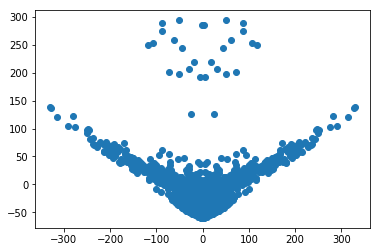

In [54]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

pca = PCA()
X_train_tr = pca.fit_transform(df_train[features])
X_test_tr = pca.transform(df_test[features])

plt.scatter(X_train_tr[:,0], X_train_tr[:,1])

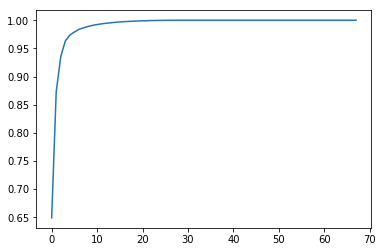

In [58]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [67]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_tr[:, :10], df_train[target])
pred = lr.predict(X_test_tr[:, :10])
probs = lr.predict_proba(X_test_tr[:, :10])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       268
          1       0.72      0.72      0.72       268

avg / total       0.72      0.72      0.72       536

Log Loss:  0.530938704189
RMSE:  0.17980356067
ROC AUC:  0.804939852974


## Naive Bayes

In [16]:
target = 'Outcome'
features = ['SeedDiff', 'WinPctDiff', 'AvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

nb = GaussianNB()
nb.fit(df_train[features], df_train[target])

pred = nb.predict(df_test[features])
probs = nb.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.71      0.70      0.71       268
          1       0.70      0.71      0.71       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.885715789799
RMSE:  0.228028843688
ROC AUC:  0.763728001782


## Decision Tree

In [17]:
target = 'Outcome'
features = ['SeedDiff', 'WinPct', 'OpponentWinPct', 'AvgNetPointsFor',
            'AvgRank', 'OpponentAvgRank', 
            'TwoPointPct_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Team', 'ThreePointPct_Opponent',
            'FreeThrowPct_Team', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Team', 'OffensiveRebounds_Opponent',
            'DefensiveRebounds_Team', 'DefensiveRebounds_Opponent'
           ]

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(df_train[features], df_train[target])

pred = dt.predict(df_test[features])
probs = dt.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.64      0.70      0.67       268
          1       0.67      0.61      0.64       268

avg / total       0.66      0.66      0.66       536

Log Loss:  0.616227641986
RMSE:  0.211838082143
ROC AUC:  0.727417019381


### More Features Added

In [72]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(df_train[features], df_train[target])

pred = dt.predict(df_test[features])
probs = dt.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.70      0.73      0.72       268
          1       0.72      0.69      0.70       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.578984099098
RMSE:  0.196410857092
ROC AUC:  0.770759077746


### Random Forest

In [99]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

rf = RandomForestClassifier(n_estimators=300)
rf.fit(df_train[features], df_train[target])

pred = rf.predict(df_test[features])
probs = rf.predict_proba(df_test[features])

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.72      0.70      0.71       268
          1       0.71      0.72      0.71       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.563940802025
RMSE:  0.192789676617
ROC AUC:  0.775952327913


### PCA + Random Forest

In [97]:
target = 'Outcome'
features = ['AvgRank', 'OpponentAvgRank', 'TwoPointPct_Team',
            'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team',
            'DefensiveRebounds_Team', 'TwoPointPct_Opponent',
            'ThreePointPct_Opponent', 'FreeThrowPct_Opponent',
            'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'WinPct',
            'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst',
            'AvgNetPointsFor', 'SeedDiff', 'OpponentAvgPointsFor',
            'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins',
            'OpponentTourWins', 'TourWinsDiff', 'FieldGoalPct_Team', 'TwoPointAttPct_Team',
            'ThreePointAttPct_Team', 'FieldGoalAtt_Team', 'TwoPointAtt_Team',
            'ThreePointAtt_Team', 'FreeThrowAtt_Team', 'Assists_Team',
            'Turnovers_Team', 'Steals_Team', 'Blocks_Team', 'PersonalFouls_Team',
            'FieldGoalPct_Opponent', 'TwoPointAttPct_Opponent',
            'ThreePointAttPct_Opponent', 'FieldGoalAtt_Opponent',
            'TwoPointAtt_Opponent', 'ThreePointAtt_Opponent',
            'FreeThrowAtt_Opponent', 'Assists_Opponent', 'Turnovers_Opponent',
            'Steals_Opponent', 'Blocks_Opponent', 'PersonalFouls_Opponent',
            'AvgRankDiff', 'AvgNetPointsForDiff', 'TwoPointPctDiff',
            'ThreePointPctDiff', 'FreeThrowPctDiff', 'OffensiveReboundsDiff',
            'DefensiveReboundsDiff', 'FieldGoalPctDiff', 'TwoPointAttPctDiff',
            'ThreePointAttPctDiff', 'FieldGoalAttDiff', 'TwoPointAttDiff',
            'ThreePointAttDiff', 'FreeThrowAttDiff', 'AssistsDiff', 'TurnoversDiff',
            'StealsDiff', 'BlocksDiff', 'PersonalFoulsDiff']

pca = PCA()
X_train_tr = pca.fit_transform(df_train[features])
X_test_tr = pca.transform(df_test[features])

In [98]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train_tr, df_train[target])

pred = rf.predict(X_test_tr)
probs = rf.predict_proba(X_test_tr)

print(classification_report(df_test[target], pred))
print("Log Loss: ",log_loss(df_test[target], probs[:,1]))
print("RMSE: ",mean_squared_error(df_test[target], probs[:,1]))
print("ROC AUC: ", roc_auc_score(df_test[target], probs[:,1]))

             precision    recall  f1-score   support

          0       0.71      0.71      0.71       268
          1       0.71      0.71      0.71       268

avg / total       0.71      0.71      0.71       536

Log Loss:  0.596266592015
RMSE:  0.203523611111
ROC AUC:  0.768705446647


## Model Ensemble

## Final Model Test

In [52]:
# pull 2018 potential matchups
query = '''
    SELECT *
    FROM prod.features
    WHERE "Season Type" = 'NCAA Tourney' and
        holdout_s2 = 1
'''

conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')

df_2018 = pd.read_sql_query(query, conn)

# "Diff" Features
df_2018['AvgRankDiff'] = df_2018['AvgRank'] - df_2018['OpponentAvgRank']
df_2018['AvgNetPointsForDiff'] = df_2018['AvgNetPointsFor'] - df_2018['OpponentAvgNetPointsFor']
df_2018['TwoPointPctDiff'] = df_2018['TwoPointPct_Team'] - df_2018['TwoPointPct_Opponent']
df_2018['ThreePointPctDiff'] = df_2018['ThreePointPct_Team'] - df_2018['ThreePointPct_Opponent']
df_2018['FreeThrowPctDiff'] = df_2018['FreeThrowPct_Team'] - df_2018['FreeThrowPct_Opponent']
df_2018['OffensiveReboundsDiff'] = df_2018['OffensiveRebounds_Team'] - df_2018['OffensiveRebounds_Opponent']
df_2018['DefensiveReboundsDiff'] = df_2018['DefensiveRebounds_Team'] - df_2018['DefensiveRebounds_Opponent']
df_2018['FieldGoalPctDiff'] = df_2018['FieldGoalPct_Team'] - df_2018['FieldGoalPct_Opponent']
df_2018['TwoPointAttPctDiff'] = df_2018['TwoPointAttPct_Team'] - df_2018['TwoPointAttPct_Opponent']
df_2018['ThreePointAttPctDiff'] = df_2018['ThreePointAttPct_Team'] - df_2018['ThreePointAttPct_Opponent']
df_2018['FieldGoalAttDiff'] = df_2018['FieldGoalAtt_Team'] - df_2018['FieldGoalAtt_Opponent']
df_2018['TwoPointAttDiff'] = df_2018['TwoPointAtt_Team'] - df_2018['TwoPointAtt_Opponent']
df_2018['ThreePointAttDiff'] = df_2018['ThreePointAtt_Team'] - df_2018['ThreePointAtt_Opponent']
df_2018['FreeThrowAttDiff'] = df_2018['FreeThrowAtt_Team'] - df_2018['FreeThrowAtt_Opponent']
df_2018['AssistsDiff'] = df_2018['Assists_Team'] - df_2018['Assists_Opponent']
df_2018['TurnoversDiff'] = df_2018['Turnovers_Team'] - df_2018['Turnovers_Opponent']
df_2018['StealsDiff'] = df_2018['Steals_Team'] - df_2018['Steals_Opponent']
df_2018['BlocksDiff'] = df_2018['Blocks_Team'] - df_2018['Blocks_Opponent']
df_2018['PersonalFoulsDiff'] = df_2018['PersonalFouls_Team'] - df_2018['PersonalFouls_Opponent']

df_2018.head()

,Season,DayNum,Team,Opponent,Outcome,Score,OpponentScore,NumOT,WLoc,Season Type,...,ThreePointAttPctDiff,FieldGoalAttDiff,TwoPointAttDiff,ThreePointAttDiff,FreeThrowAttDiff,AssistsDiff,TurnoversDiff,StealsDiff,BlocksDiff,PersonalFoulsDiff
0,2018,999,1104,1437,0.0,58.0,81.0,None,None,NCAA Tourney,...,-0.109914,-6.3333,2.9091,-9.2424,5.3939,-4.1212,3.8788,-0.24242,1.63636,3.0000
1,2018,999,1104,1439,1.0,86.0,83.0,None,None,NCAA Tourney,...,-0.042777,-1.3627,1.5758,-2.9384,2.0889,-3.8211,2.2424,0.74291,3.22287,3.3930
2,2018,999,1112,1138,0.0,68.0,89.0,None,None,NCAA Tourney,...,-0.077007,-7.9062,-0.1751,-7.7311,1.9773,-1.7879,-0.2264,-1.09470,0.35511,-3.6742
3,2018,999,1113,1393,0.0,56.0,60.0,None,None,NCAA Tourney,...,0.065397,6.0105,-0.2583,6.2688,3.3062,3.0083,-1.6271,-0.61250,-2.02708,2.7167
4,2018,999,1116,1139,0.0,62.0,79.0,None,None,NCAA Tourney,...,-0.053660,-1.1259,2.3920,-3.5180,6.1107,0.6667,-0.1259,-0.51042,1.75947,1.9289


In [67]:
pred_ix[0]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132, 4555])

In [63]:
df_pred = df_2018[df_2018['Outcome'].notnull()]
pred_ix = np.where(df_2018['Outcome'].notnull())

In [68]:
# final predictions
pred = lr.predict(ss.transform(df_2018[features]))
probs = lr.predict_proba(ss.transform(df_2018[features]))

print(classification_report(df_pred[target], pred[pred_ix[0]]))
print("Log Loss: ",log_loss(df_pred[target], probs[pred_ix[0],1]))
print("RMSE: ",mean_squared_error(df_pred[target], probs[pred_ix[0],1]))
print("ROC AUC: ", roc_auc_score(df_pred[target], probs[pred_ix[0],1]))

             precision    recall  f1-score   support

        0.0       0.69      0.69      0.69        67
        1.0       0.69      0.69      0.69        67

avg / total       0.69      0.69      0.69       134

Log Loss:  0.613988895515
RMSE:  0.201754442554
ROC AUC:  0.759634662508


In [27]:
out = df_2018[['Season', 'Team', 'Opponent']].copy()
out['Pred'] = probs[:, 1]
out2 = out[out['Team'] < out['Opponent']]

In [42]:
datarows = []
for i in out2.itertuples(index=False):
    row = ("_".join([str(i.Season), str(i.Team), str(i.Opponent)]), float(i.Pred))
    datarows.append(row)

In [50]:
import csv

with open('/Users/Steve/Desktop/test_out.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['ID','Pred'])
    for row in datarows:
        csv_out.writerow(row)

In [48]:
datarows

[('2018_1104_1437', 0.11120493915062371),
 ('2018_1104_1439', 0.4326265353133182),
 ('2018_1112_1138', 0.8767973334829492),
 ('2018_1113_1393', 0.46712130071198804),
 ('2018_1116_1139', 0.2961148479062558),
 ('2018_1120_1158', 0.8436737553320197),
 ('2018_1138_1246', 0.15401012639506237),
 ('2018_1139_1345', 0.41437533724708203),
 ('2018_1153_1209', 0.956447905368604),
 ('2018_1153_1305', 0.8472642322313522),
 ('2018_1155_1308', 0.6369634174606894),
 ('2018_1166_1243', 0.3981721625456534),
 ('2018_1168_1345', 0.03399617758492676),
 ('2018_1172_1246', 0.2266717916302501),
 ('2018_1181_1233', 0.9785821496908916),
 ('2018_1196_1382', 0.755197796272676),
 ('2018_1196_1403', 0.38225365671105405),
 ('2018_1199_1211', 0.21494608067154145),
 ('2018_1199_1276', 0.3420387055960455),
 ('2018_1211_1422', 0.881757035585388),
 ('2018_1222_1276', 0.47847460121944635),
 ('2018_1222_1361', 0.7393365738465395),
 ('2018_1242_1335', 0.9677767339311675),
 ('2018_1242_1371', 0.750852278322448),
 ('2018_1242